In [1]:
import os

PATH = '/kaggle/input/fracture-detection-using-x-ray-images/data'
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

2025-05-02 19:47:08.777628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746215229.084760      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746215229.168810      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
base_model.trainable = False
feature_extractor = tf.keras.Sequential([base_model, GlobalAveragePooling2D()])

2025-05-02 19:47:35.155086: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_features(generator):
    features = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        batch_features = feature_extractor.predict(batch_images, verbose=0)
        features.extend(batch_features)
        labels.extend(batch_labels)
    return np.array(features), np.array(labels)


X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(val_generator)
#X_test, y_test = extract_features(test_generator)

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
#y_test = np.argmax(y_test, axis=1)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
model.fit(X_train, y_train)

pred_val = model.predict(X_val)
print("Val Accuracy:", accuracy_score(y_val, pred_val))
print(classification_report(y_val, pred_val))

Val Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       360
           1       0.69      0.77      0.73       240

    accuracy                           0.77       600
   macro avg       0.76      0.77      0.76       600
weighted avg       0.78      0.77      0.77       600



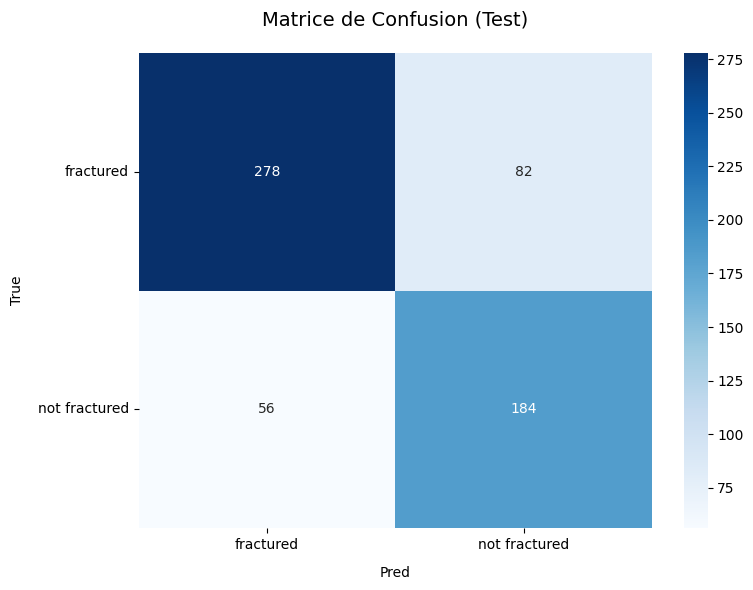

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = list(train_generator.class_indices.keys())
cm = confusion_matrix(y_val, pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)

plt.title('Matrice de Confusion (Test)', pad=20, fontsize=14)
plt.xlabel('Pred', labelpad=10)
plt.ylabel('True', labelpad=10)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()